<a href="https://colab.research.google.com/github/Ajju7669/glaucoma_detection/blob/master/desnet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.layers import Dense
from keras import Sequential
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.python.keras import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

Using TensorFlow backend.


In [0]:
pip install -U keras

In [0]:
np.random.seed(2019)
tf.random.set_seed(2019)

In [4]:
train_df = pd.read_csv('drive/My Drive/Glaucoma Dataset/train.csv')
test_df = pd.read_csv('drive/My Drive/Glaucoma Dataset/test.csv')
print(train_df.shape)
print(test_df.shape)
test_df.head()

(3662, 2)
(1928, 1)


,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

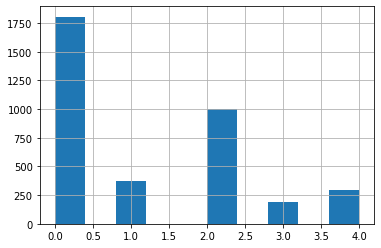

In [5]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

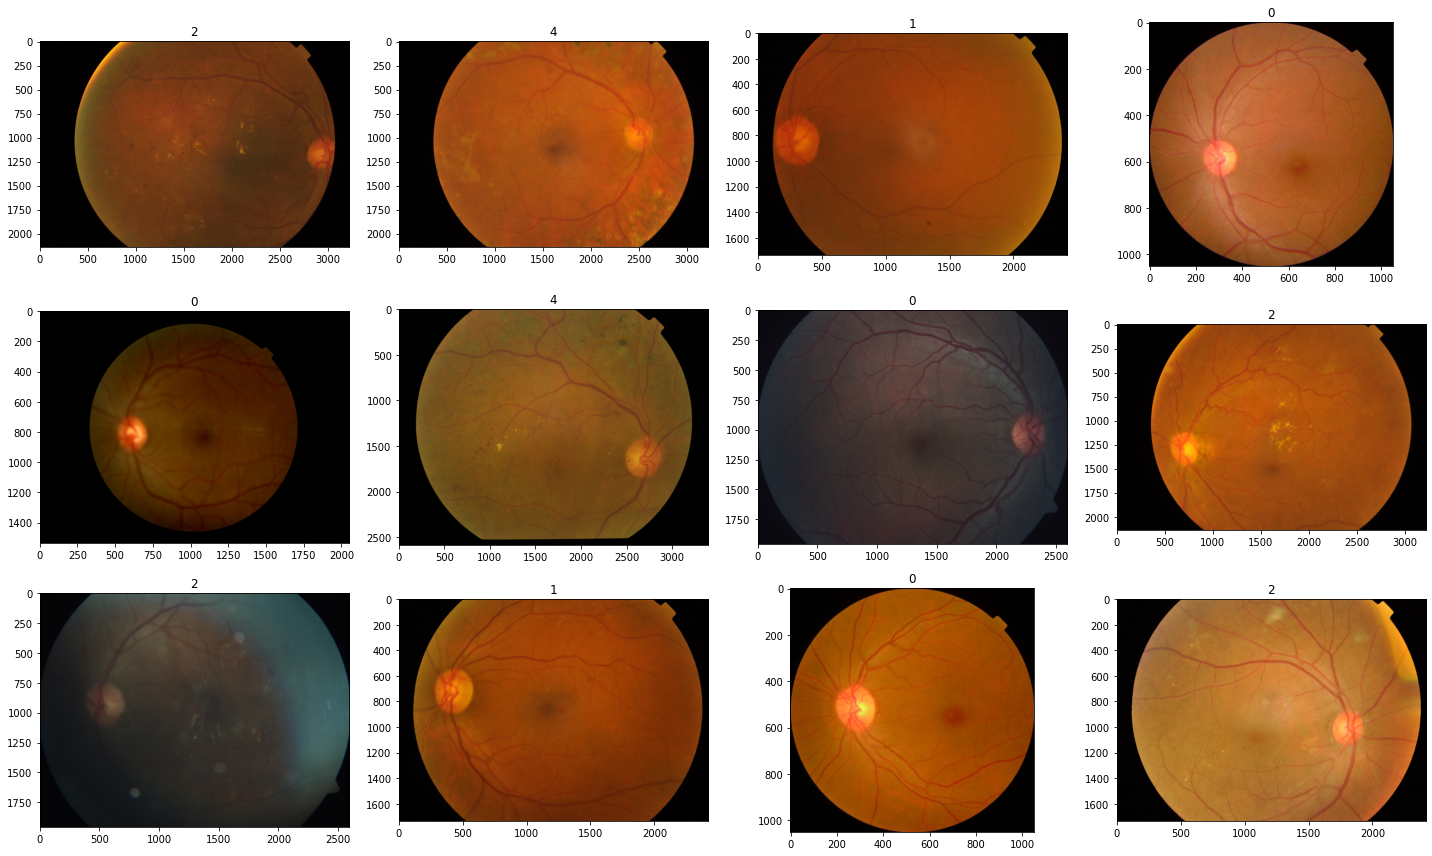

In [6]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'drive/My Drive/Glaucoma Dataset/train_images1/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

In [0]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [8]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
          f'drive/My Drive/Glaucoma Dataset/train_images1/{image_id}.png'
      )

100%|██████████| 3662/3662 [1:10:28<00:00,  1.15s/it]


In [9]:
N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)


for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        f'drive/My Drive/Glaucoma Dataset/test_images1/{image_id}.png'
    )

100%|██████████| 1928/1928 [33:40<00:00,  1.05s/it]


In [10]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(3662, 224, 224, 3)
(3662, 5)
(1928, 224, 224, 3)


In [11]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [0]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=0.15, 
    random_state=2019
)

In [0]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [0]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)
# Using Mixup
mixup_generator = MixupGenerator(x_train, y_train, batch_size=BATCH_SIZE, alpha=0.2, datagen=create_datagen())()

In [0]:
true_labels = np.array([1, 0, 1, 1, 0, 1])
pred_labels = np.array([1, 0, 0, 0, 0, 1])

In [16]:
accuracy_score(true_labels, pred_labels)

0.6666666666666666

In [17]:
cohen_kappa_score(true_labels, pred_labels)

0.3999999999999999

In [0]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')
            

        return

In [0]:
densenet = DenseNet121(
    weights='drive/My Drive/Desnet/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [0]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [21]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [23]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)

Epoch 1/15
98/97 [==============================] - 49s 504ms/step - loss: 0.0647 - accuracy: 0.9751 - val_loss: 0.1302 - val_accuracy: 0.9505
val_kappa: 0.8689
Validation Kappa has improved. Saving model.
Epoch 2/15
98/97 [==============================] - 49s 502ms/step - loss: 0.0630 - accuracy: 0.9751 - val_loss: 0.1138 - val_accuracy: 0.9596
val_kappa: 0.8992
Validation Kappa has improved. Saving model.
Epoch 3/15
98/97 [==============================] - 49s 500ms/step - loss: 0.0589 - accuracy: 0.9787 - val_loss: 0.1404 - val_accuracy: 0.9629
val_kappa: 0.9110
Validation Kappa has improved. Saving model.
Epoch 4/15
98/97 [==============================] - 49s 499ms/step - loss: 0.0526 - accuracy: 0.9804 - val_loss: 0.1250 - val_accuracy: 0.9549
val_kappa: 0.8980
Epoch 5/15
98/97 [==============================] - 49s 499ms/step - loss: 0.0514 - accuracy: 0.9817 - val_loss: 0.1150 - val_accuracy: 0.9607
val_kappa: 0.9031
Epoch 6/15
98/97 [==============================] - 49s 500m

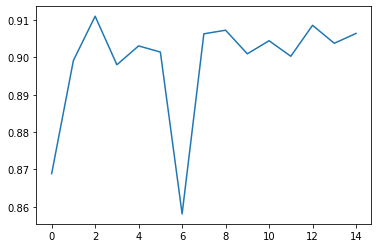

In [24]:
plt.plot(kappa_metrics.val_kappas)


In [0]:
model.load_weights('model.h5')
y_val_pred = model.predict(x_val)

def compute_score_inv(threshold):
    y1 = y_val_pred > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')
    
    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 0.5, method='nelder-mead'
)

best_threshold = simplex['x'][0]

In [0]:
y_test = model.predict(x_test) > 0.5
y_test = y_test.astype(int).sum(axis=1) - 1

test_df['diagnosis'] = y_test
test_df.to_csv('submission.csv',index=False)

In [27]:
sub_df = pd.read_csv('submission.csv')
display(sub_df.head(10))

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,3
7,0111b949947e,1
8,01499815e469,3
9,0167076e7089,1
